##Inisialisasi & Impor Library

In [1]:
!pip install yfinance
!pip install --upgrade yfinance

In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.impute import SimpleImputer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU
from statsmodels.tsa.arima.model import ARIMA

##Data Loading

In [3]:
# Ambil data USD/IDR
df = yf.download("USDIDR=X", interval='1h')
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Open,High,Low,Close,Volume
Ticker,USDIDR=X,USDIDR=X,USDIDR=X,USDIDR=X,USDIDR=X
Datetime,,,,,
2023-05-26 06:00:00+00:00,14959.0,14959.0,14949.0,14959.0,0
2023-05-26 07:00:00+00:00,14956.0,14968.0,14949.0,14949.0,0
2023-05-26 13:00:00+00:00,14955.0,14955.0,14949.0,14949.0,0
2023-05-26 14:00:00+00:00,14949.0,14955.0,14949.0,14949.0,0
2023-05-26 15:00:00+00:00,14955.0,14955.0,14949.0,14949.0,0
...,...,...,...,...,...
2025-05-23 09:00:00+00:00,16218.0,16218.0,16215.0,16215.0,0
2025-05-23 10:00:00+00:00,16215.0,16215.0,16215.0,16215.0,0


##Data Understanding

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7537 entries, 2023-05-26 06:00:00+00:00 to 2025-05-23 19:00:00+00:00
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   (Open, USDIDR=X)    7537 non-null   float64
 1   (High, USDIDR=X)    7537 non-null   float64
 2   (Low, USDIDR=X)     7537 non-null   float64
 3   (Close, USDIDR=X)   7537 non-null   float64
 4   (Volume, USDIDR=X)  7537 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 353.3 KB


In [5]:
print('Total missing value in the dataframe:', df.isnull().sum().sum(), 'records')

Total missing value in the dataframe: 0 records


In [6]:
print('Columns with missing value:')
print(df.isnull().sum())

Columns with missing value:
Price   Ticker  
Open    USDIDR=X    0
High    USDIDR=X    0
Low     USDIDR=X    0
Close   USDIDR=X    0
Volume  USDIDR=X    0
dtype: int64


In [7]:
col_with_missing = [col for col in df.columns if df[col].isnull().any()]
print('Column with missing value:', col_with_missing)

Column with missing value: []


In [8]:
imputer = SimpleImputer()
if col_with_missing:
    df[col_with_missing] = imputer.fit_transform(df[col_with_missing])
else:
    print("No columns with missing values found. Skipping imputation.")

df.head()

No columns with missing values found. Skipping imputation.


Price,Open,High,Low,Close,Volume
Ticker,USDIDR=X,USDIDR=X,USDIDR=X,USDIDR=X,USDIDR=X
Datetime,,,,,
2023-05-26 06:00:00+00:00,14959.0,14959.0,14949.0,14959.0,0
2023-05-26 07:00:00+00:00,14956.0,14968.0,14949.0,14949.0,0
2023-05-26 13:00:00+00:00,14955.0,14955.0,14949.0,14949.0,0
2023-05-26 14:00:00+00:00,14949.0,14955.0,14949.0,14949.0,0
2023-05-26 15:00:00+00:00,14955.0,14955.0,14949.0,14949.0,0


In [9]:
print('Total missing value in the dataframe:', df.isnull().sum().sum(), 'records')

Total missing value in the dataframe: 0 records


In [10]:
df.describe()

Price,Open,High,Low,Close,Volume
Ticker,USDIDR=X,USDIDR=X,USDIDR=X,USDIDR=X,USDIDR=X
count,7537.000000,7537.000000,7537.000000,7537.000000,7537.0
mean,15813.245456,15820.040666,15804.002720,15810.097983,0.0
std,485.879644,486.442374,484.715497,485.087069,0.0
min,14814.000000,14829.000000,14814.000000,14819.000000,0.0
25%,15479.000000,15485.000000,15469.000000,15479.000000,0.0
50%,15755.000000,15762.000000,15745.000000,15750.000000,0.0
75%,16239.000000,16247.000000,16225.000000,16234.000000,0.0
max,16964.000000,16969.000000,16954.000000,16959.000000,0.0


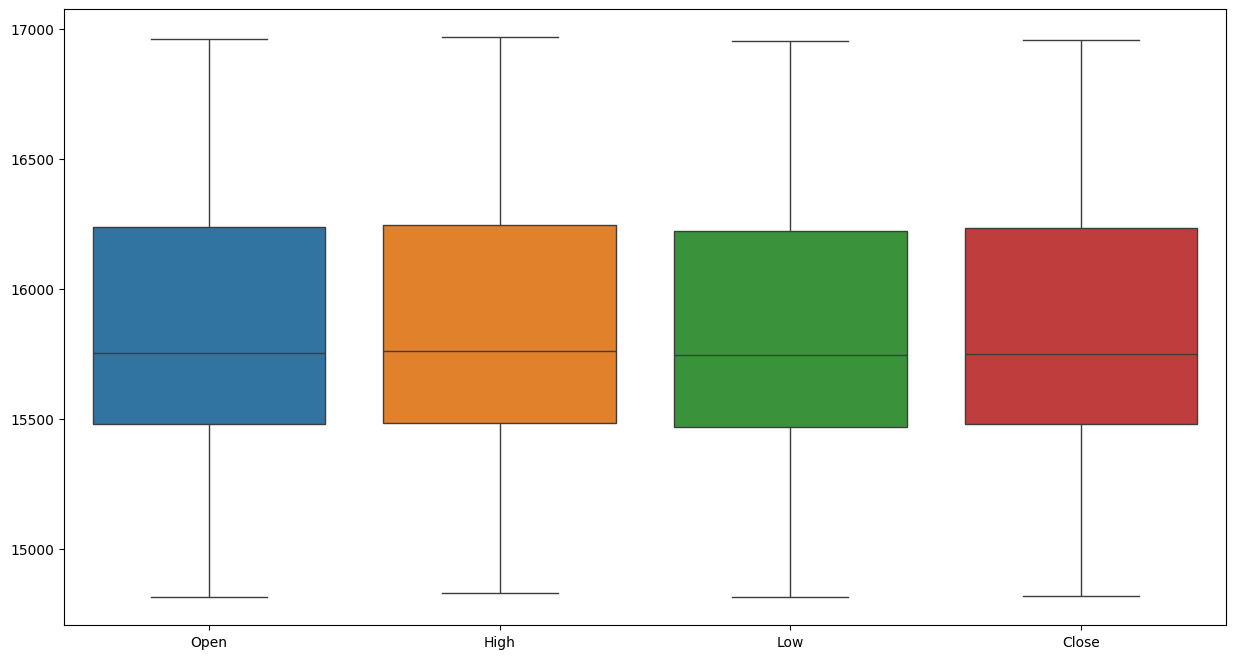

In [11]:
numerical_col = [col for col in df.columns if df[col].dtypes == 'float64']
plt.figure(figsize=(15,8))
sns.boxplot(data=df[numerical_col])
plt.show()

**Univariate Analysis**

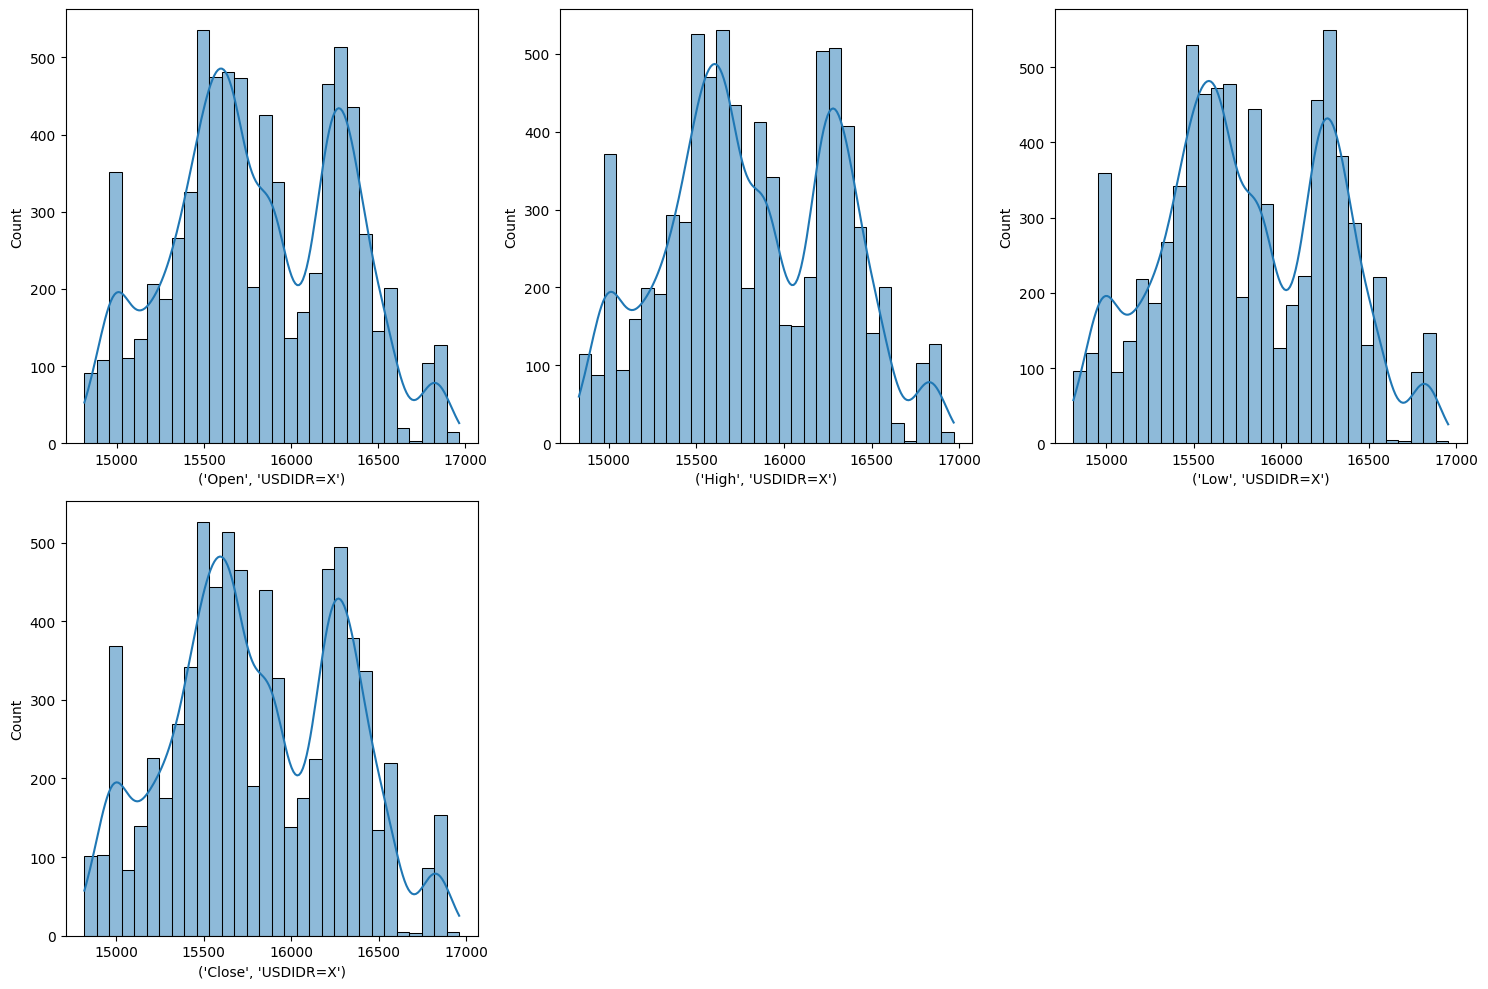

In [12]:
cols = 3
rows = 2
fig = plt.figure(figsize=(cols * 5, rows * 5))

for i, col in enumerate(numerical_col):
  ax = fig.add_subplot(rows, cols, i + 1)
  sns.histplot(x=df[col], bins=30, kde=True, ax=ax)
fig.tight_layout()
plt.show()

**Multivariate Analysis**

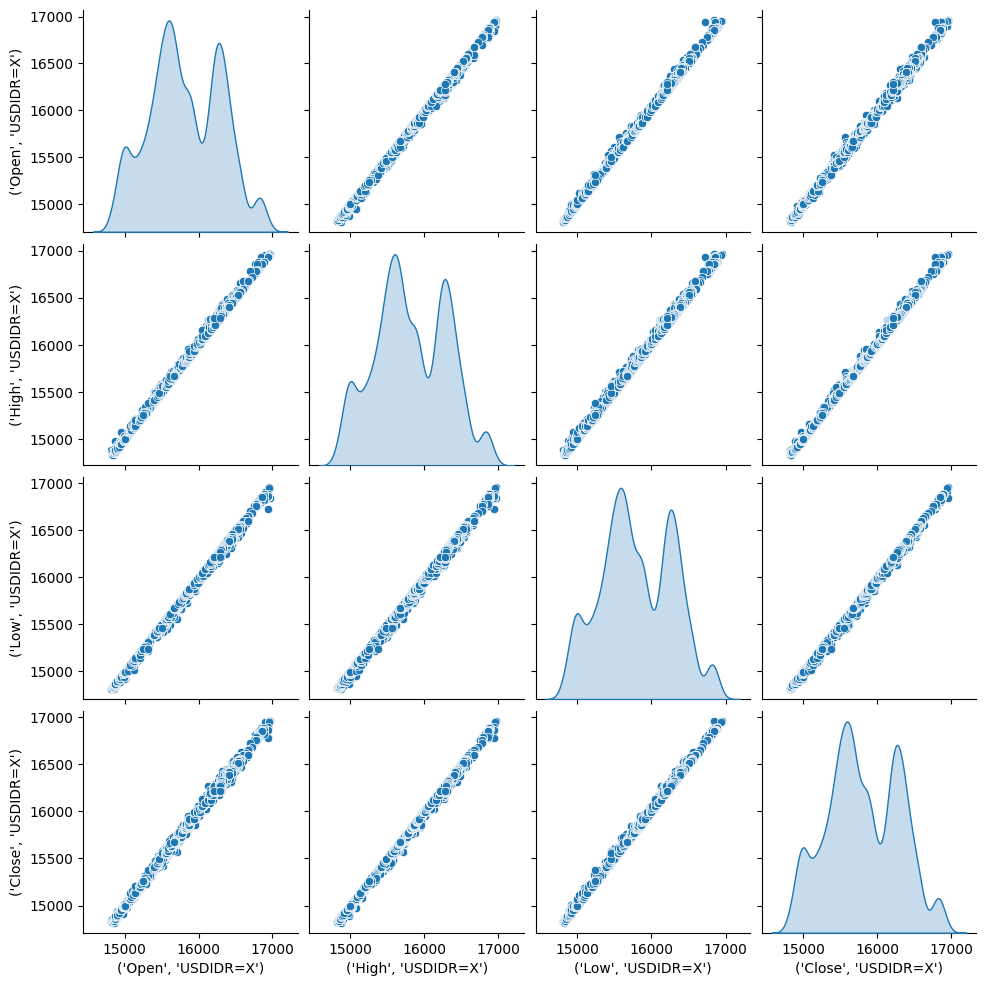

In [13]:
sns.pairplot(df[numerical_col], diag_kind='kde')
plt.show()

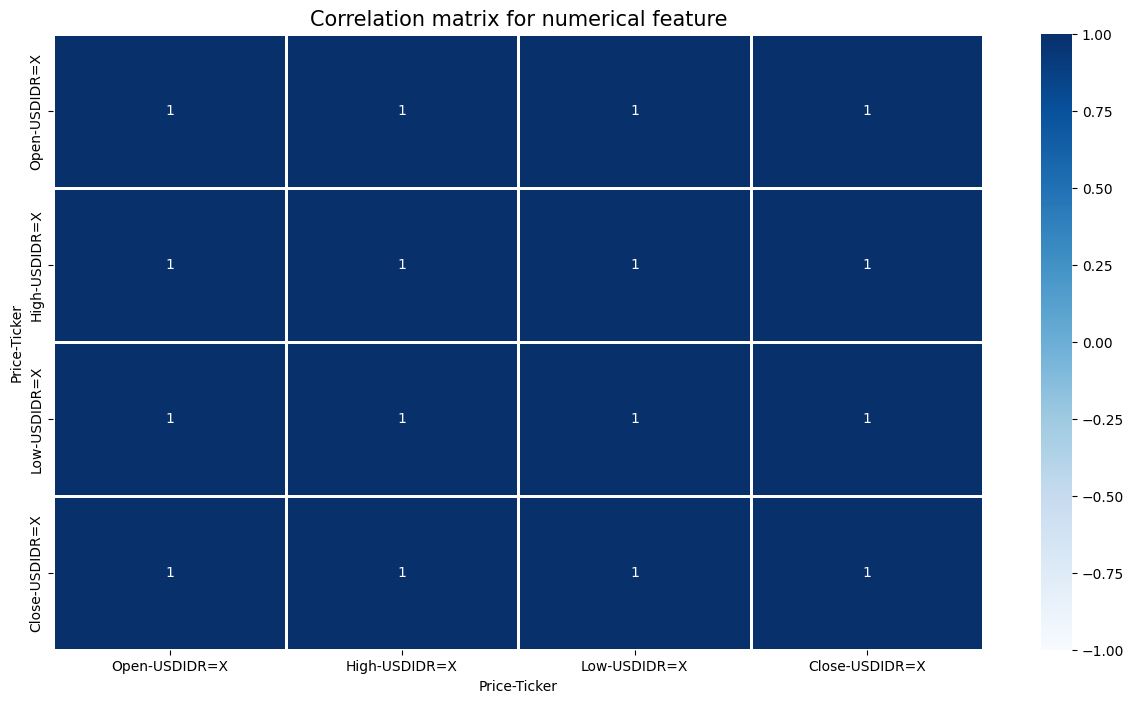

In [14]:
plt.figure(figsize=(15,8))
corr = df[numerical_col].corr().round(2)
sns.heatmap(data=corr, annot=True, vmin=-1, vmax=1, cmap='Blues', linewidth=1)
plt.title('Correlation matrix for numerical feature', size=15)
plt.show()

##Data Preparation

In [15]:
df = df[['Close']]
df.head()

Price,Close
Ticker,USDIDR=X
Datetime,
2023-05-26 06:00:00+00:00,14959.0
2023-05-26 07:00:00+00:00,14949.0
2023-05-26 13:00:00+00:00,14949.0
2023-05-26 14:00:00+00:00,14949.0
2023-05-26 15:00:00+00:00,14949.0


In [16]:
# Normalisasi data ke rentang 0-1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(df)

train_size = int(len(scaled_dataset) * 0.80)
test_size = len(scaled_dataset) - train_size
train_data, test_data = scaled_dataset[0:train_size,:], scaled_dataset[train_size:len(scaled_dataset),:]

In [17]:
# Fungsi untuk membuat dataset sekuensial
def create_sequences(df, look_back=1):
    X, Y = [], []
    for i in range(len(df) - look_back - 1):
        a = df[i:(i + look_back), 0]
        X.append(a)
        Y.append(df[i + look_back, 0])
    return np.array(X), np.array(Y)

In [18]:
# look_back adalah jumlah step waktu sebelumnya yang digunakan untuk prediksi step berikutnya
look_back = 30
X_train, y_train = create_sequences(train_data, look_back)
X_test, y_test = create_sequences(test_data, look_back)

In [19]:
# Reshape input menjadi [samples, time steps, features] yang diperlukan oleh LSTM/GRU
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(f"Ukuran X_train: {X_train.shape}")
print(f"Ukuran y_train: {y_train.shape}")
print(f"Ukuran X_test: {X_test.shape}")
print(f"Ukuran y_test: {y_test.shape}")

Ukuran X_train: (5998, 30, 1)
Ukuran y_train: (5998,)
Ukuran X_test: (1477, 30, 1)
Ukuran y_test: (1477,)


##Modeling

In [20]:
#LSTM
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [21]:
#BILSTM
def build_bidirectional_lstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(50, return_sequences=False)))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [22]:
#GRU
def build_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [23]:
input_shape = (X_train.shape[1], 1)

In [24]:
epochs = 100
batch_size = 32

In [25]:
# Model LSTM
print("\nMelatih Model LSTM...")
lstm_model = build_lstm_model(input_shape)
history_lstm = lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
lstm_model.summary()


Melatih Model LSTM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - loss: 0.0190 - val_loss: 3.3473e-04
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 9.6593e-04 - val_loss: 3.1950e-04
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 32ms/step - loss: 7.6342e-04 - val_loss: 3.9133e-04
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 6.1527e-04 - val_loss: 2.7996e-04
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 5.5721e-04 - val_loss: 3.7056e-04
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 4.8012e-04 - val_loss: 4.2508e-04
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 4.2861e-04 - val_loss: 0.0011
Epoch 9/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - loss: 4.8489e-04 - val_loss: 6.0921e-04
Epoch 10/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 39ms/step - loss: 3.9956e-04 - val_loss: 2.8567e-04
Epoch 11/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 37m

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95,705 (373.85 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 63,804 (249.24 KB)

In [26]:
# Model Bidirectional LSTM
print("\nMelatih Model Bidirectional LSTM...")
bilstm_model = build_bidirectional_lstm_model(input_shape)
history_bilstm = bilstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
bilstm_model.summary()


Melatih Model Bidirectional LSTM...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 19s 64ms/step - loss: 0.0138 - val_loss: 5.8924e-04
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - loss: 8.8051e-04 - val_loss: 6.7678e-04
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - loss: 6.4640e-04 - val_loss: 5.1958e-04
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - loss: 5.2877e-04 - val_loss: 4.1163e-04
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - loss: 4.7133e-04 - val_loss: 1.9178e-04
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - loss: 4.1823e-04 - val_loss: 5.1144e-04
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - loss: 3.5900e-04 - val_loss: 3.3482e-04
Epoch 9/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - loss: 3.7612e-04 - val_loss: 3.0976e-04
Epoch 10/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 3.2752e-04 - val_loss: 1.5909e-04
Epoch 11/100
188/188 ━━━━━━━━━━━━━━━━━━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 100)        │        20,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 100)            │        60,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 251,255 (981.47 KB)

 Trainable params: 83,751 (327.15 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 167,504 (654.32 KB)

In [27]:
# Model GRU
print("\nMelatih Model GRU...")
gru_model = build_gru_model(input_shape)
history_gru = gru_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1)
gru_model.summary()


Melatih Model GRU...
Epoch 1/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - loss: 0.0147 - val_loss: 5.6323e-04
Epoch 2/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - loss: 0.0014 - val_loss: 3.4541e-04
Epoch 3/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 8.9935e-04 - val_loss: 2.4927e-04
Epoch 4/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - loss: 5.9638e-04 - val_loss: 3.0950e-04
Epoch 5/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 43ms/step - loss: 5.1237e-04 - val_loss: 4.4231e-04
Epoch 6/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 4.2262e-04 - val_loss: 2.0361e-04
Epoch 7/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 4.0330e-04 - val_loss: 1.9994e-04
Epoch 8/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 8s 44ms/step - loss: 4.1559e-04 - val_loss: 3.6183e-04
Epoch 9/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 3.5229e-04 - val_loss: 2.3129e-04
Epoch 10/100
188/188 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 3.5783e-04 - val_loss: 1.2207e-04
Epoch 11/100
188/188

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 50)         │         7,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 73,655 (287.72 KB)

 Trainable params: 24,551 (95.90 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 49,104 (191.82 KB)

In [28]:
# Prediksi menggunakan model LSTM
train_predict_lstm = lstm_model.predict(X_train)
test_predict_lstm = lstm_model.predict(X_test)

# Prediksi menggunakan model Bidirectional LSTM
train_predict_bilstm = bilstm_model.predict(X_train)
test_predict_bilstm = bilstm_model.predict(X_test)

# Prediksi menggunakan model GRU
train_predict_gru = gru_model.predict(X_train)
test_predict_gru = gru_model.predict(X_test)

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [29]:
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

train_predict_bilstm = scaler.inverse_transform(train_predict_bilstm)
test_predict_bilstm = scaler.inverse_transform(test_predict_bilstm)

train_predict_gru = scaler.inverse_transform(train_predict_gru)
test_predict_gru = scaler.inverse_transform(test_predict_gru)

##Evaluasi

In [30]:
def plot_predictions(model_name, train_actual, train_predict, test_actual, test_predict, look_back, scaled_dataset):
    plt.figure(figsize=(15,6))

    # Plot baseline dan prediksi training
    train_predict_plot = np.empty_like(scaled_dataset)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[look_back:len(train_predict)+look_back, :] = train_predict

    # Plot baseline dan prediksi testing
    test_predict_plot = np.empty_like(scaled_dataset)
    test_predict_plot[:, :] = np.nan
    # Penyesuaian indeks untuk test_predict_plot
    test_start_index = len(train_predict) + (look_back * 2) + 1
    test_predict_plot[test_start_index:len(scaled_dataset)-1, :] = test_predict


    plt.plot(scaler.inverse_transform(scaled_dataset), label='Data Aktual Keseluruhan')
    plt.plot(train_predict_plot, label='Prediksi Training')
    plt.plot(test_predict_plot, label='Prediksi Testing')
    plt.title(f'Prediksi Harga USD/IDR menggunakan {model_name}')
    plt.xlabel('Waktu')
    plt.ylabel('Harga USD/IDR')
    plt.legend()
    plt.show()

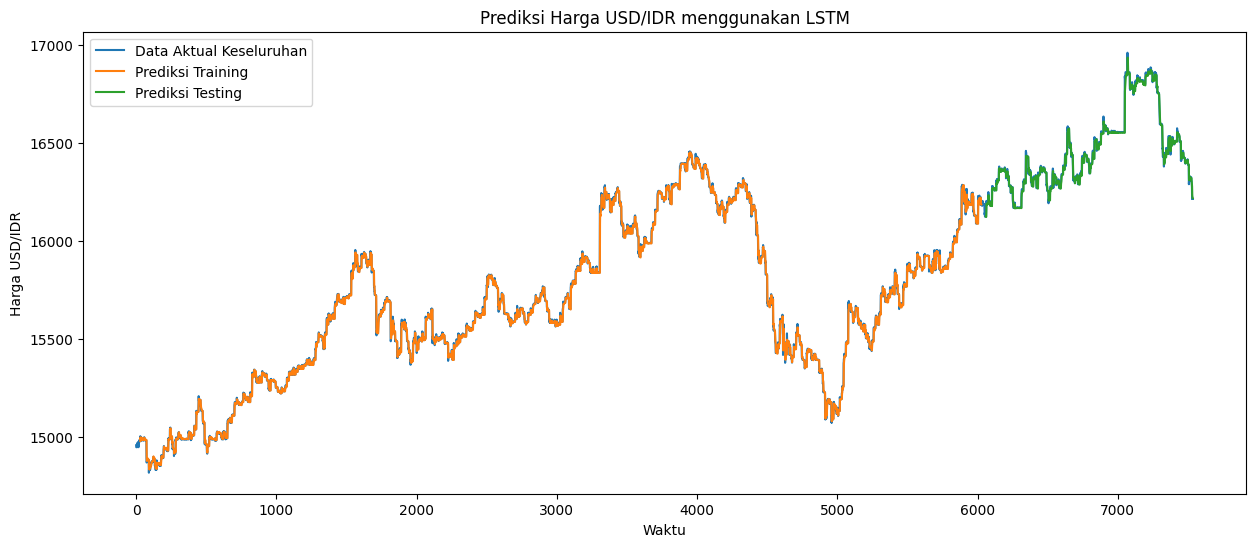

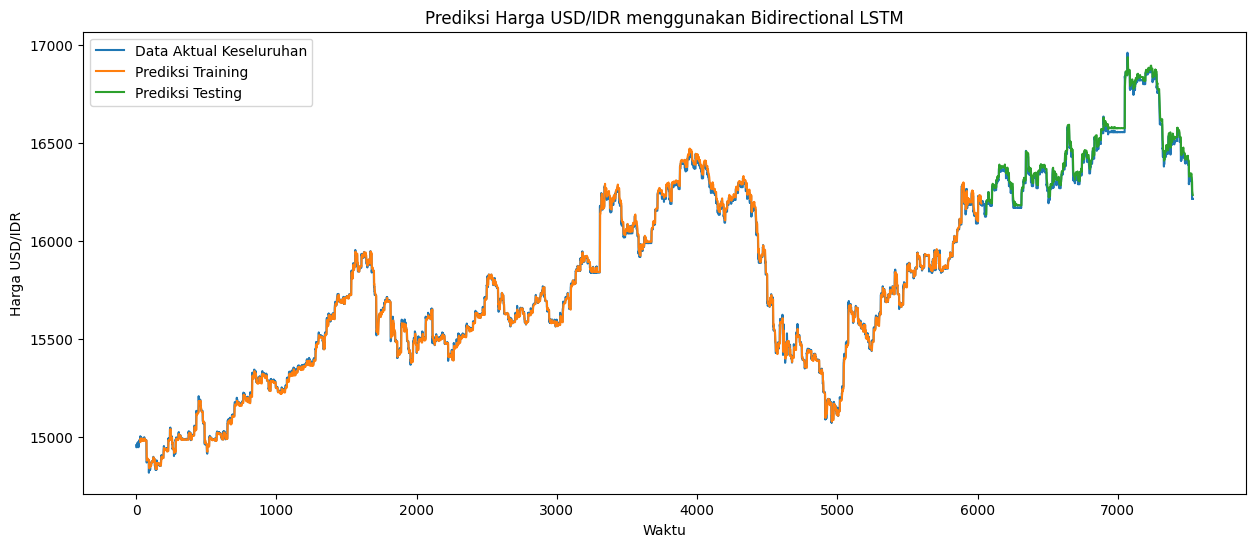

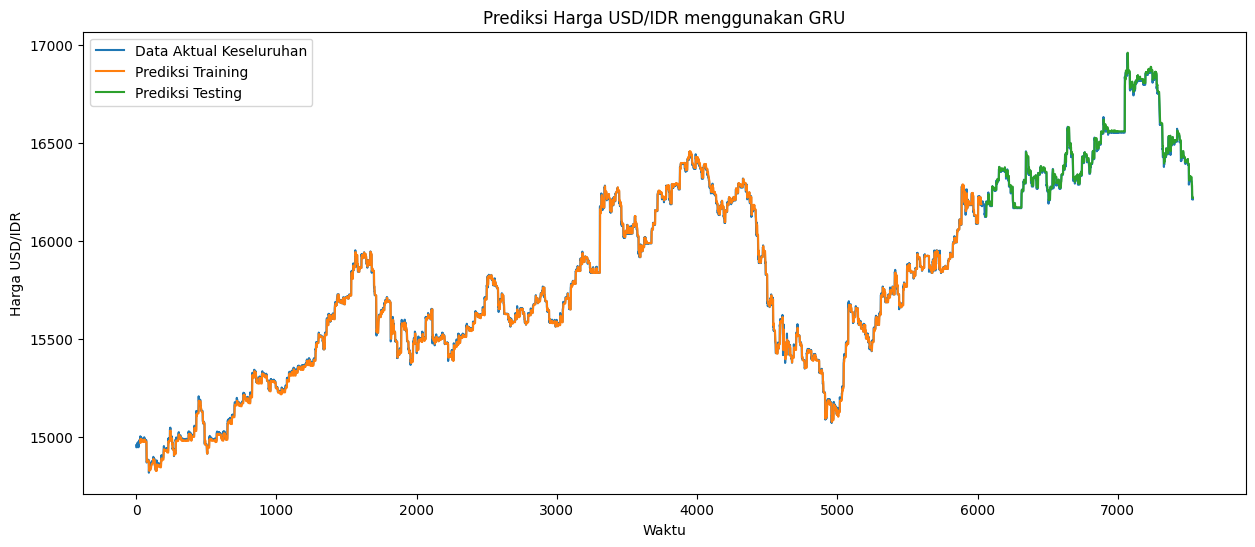

In [31]:
# Visualisasi untuk LSTM
plot_predictions('LSTM', y_train_actual, train_predict_lstm, y_test_actual, test_predict_lstm, look_back, scaled_dataset)

# Visualisasi untuk Bidirectional LSTM
plot_predictions('Bidirectional LSTM', y_train_actual, train_predict_bilstm, y_test_actual, test_predict_bilstm, look_back, scaled_dataset)

# Visualisasi untuk GRU
plot_predictions('GRU', y_train_actual, train_predict_gru, y_test_actual, test_predict_gru, look_back, scaled_dataset)

In [32]:
# Setelah melatih LSTM
final_lstm_train_loss = history_lstm.history['loss'][-1]
final_lstm_val_loss = history_lstm.history['val_loss'][-1]
print(f"LSTM Final Train Loss (MSE): {final_lstm_train_loss}")
print(f"LSTM Final Validation Loss (MSE): {final_lstm_val_loss}")

# Setelah melatih BiLSTM
final_bilstm_train_loss = history_bilstm.history['loss'][-1]
final_bilstm_val_loss = history_bilstm.history['val_loss'][-1]
print(f"BiLSTM Final Train Loss (MSE): {final_bilstm_train_loss}")
print(f"BiLSTM Final Validation Loss (MSE): {final_bilstm_val_loss}")

# Setelah melatih GRU
final_gru_train_loss = history_gru.history['loss'][-1]
final_gru_val_loss = history_gru.history['val_loss'][-1]
print(f"GRU Final Train Loss (MSE): {final_gru_train_loss}")
print(f"GRU Final Validation Loss (MSE): {final_gru_val_loss}")

LSTM Final Train Loss (MSE): 0.0003124767972622067
LSTM Final Validation Loss (MSE): 7.17282309778966e-05
BiLSTM Final Train Loss (MSE): 0.00020819880592171103
BiLSTM Final Validation Loss (MSE): 0.00013370290980674326
GRU Final Train Loss (MSE): 0.00030866285669617355
GRU Final Validation Loss (MSE): 7.344075856963173e-05


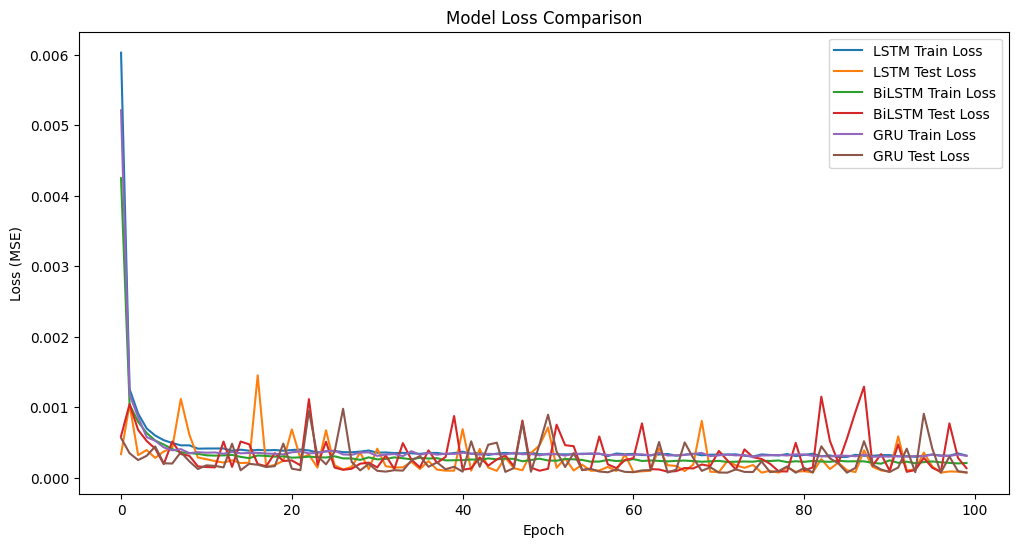

In [33]:
# Visualisasi loss
plt.figure(figsize=(12, 6))
plt.plot(history_lstm.history['loss'], label='LSTM Train Loss')
plt.plot(history_lstm.history['val_loss'], label='LSTM Test Loss')
plt.plot(history_bilstm.history['loss'], label='BiLSTM Train Loss')
plt.plot(history_bilstm.history['val_loss'], label='BiLSTM Test Loss')
plt.plot(history_gru.history['loss'], label='GRU Train Loss')
plt.plot(history_gru.history['val_loss'], label='GRU Test Loss')
plt.title('Model Loss Comparison')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend()
plt.show()